Lab 3: Regression and income inequality
================

In this lab, we'll use the "correlates of state policy" data again, this time to play with linear regression models.

You'll need to install statsmodels.

Our target outcome will be **income inequality**. This is an incredibly complex phenomenon, and we cannot hope to do it justice with the correlational analyses undertaken in this little lab. Nonetheless, it's fun to understand inequality using publicly available data. It's also worth thinking about weaknesses in this analysis, and how it could be made more robust.

In [4]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

[Statsmodels](http://www.statsmodels.org/stable/index.html) is a python package for regression analysis.

You can install it (in python3) using the command below.

In [5]:
# you can run shell commands in jupyter using the ! cell magic
! pip3 install --user statsmodels
## uncomment for python2
#! pip install --user statsmodels

In [6]:
import statsmodels.formula.api as sm

Let's load the data about US states again. Please copy it into this directory from Lab1.

In [7]:
! ln -s ../lab1/correlatesofstatepolicyprojectv1_10.csv 

ln: failed to create symbolic link './correlatesofstatepolicyprojectv1_10.csv': File exists


In [10]:
df_states = pandas.read_csv('correlatesofstatepolicyprojectv1_10.csv',low_memory=False)

Our outcome variable is the percentage of income going to the top 1%.

In [11]:
# build a dataframe of cases in which this is not null
df_ineq = df_states[~df_states['incshare_top1'].isnull()]
# check that it worked
any(df_ineq['incshare_top1'].isnull())

False

Let's plot change over time

In [13]:
df_ga = df_ineq[df_ineq['state']=='Georgia']
df_ny = df_ineq[df_ineq['state']=='New York']
df_ca = df_ineq[df_ineq['state']=='California']

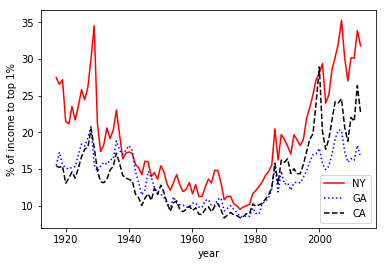

In [14]:
linestyles=['r-','b:','k--']
for df,linestyle in zip([df_ny,df_ga,df_ca],linestyles):
    plt.plot(df['year'],df['incshare_top1'],linestyle);
plt.ylabel('% of income to top 1%')
plt.xlabel('year');
plt.legend(['NY','GA','CA']);

Lots of diversity across states and over time. Why? Let's try to answer by running a series of regressions. 

We'll start with a simple regression: inequality against total population. 

(Q: what is the null hypothesis?)

In [15]:
# ols stands for "ordinary least squares", which is a way of estimating a linear regression model
# we specify the regression using the formula `response ~ predictor1 + predictor2 + ...`
# calling sm.old() creates the regression object
# calling the fit() method estimates the parameters 
result = sm.ols(formula='incshare_top1 ~ poptotal', data=df_ineq).fit()

In [16]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.040     
Dependent Variable: incshare_top1    AIC:                26525.3614
Date:               2017-09-13 15:56 BIC:                26538.2325
No. Observations:   4608             Log-Likelihood:     -13261.   
Df Model:           1                F-statistic:        191.9     
Df Residuals:       4606             Prob (F-statistic): 8.59e-43  
R-squared:          0.040            Scale:              18.505    
--------------------------------------------------------------------
                Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept      11.9975    0.0838  143.1005  0.0000  11.8331  12.1618
poptotal        0.0000    0.0000   13.8540  0.0000   0.0000   0.0000
-------------------------------------------------------------------
Omnibus:             1885.178      Durbin-Watson:         0.151    
Prob(Omnibus):       0.000         Jarque-Bera (JB):      11580.245
Skew:                1.845         Prob(JB):              0.000    
Kurtosis:            9.833         Condition No.:         7632743  
===================================================================
* The condition number is large (8e+06). This might indicate
strong multicollinearity or other numerical problems.
"""

Lots to interpret here! Key things: 

- $R^2 = 0.04, F=191.9, P(F) \ll 0.01$. The model fit is not great, but significantly better than chance.
- `coef, t, P>|t|` for `poptotal`: these indicate that the coefficient is small, but the SE is even smaller, so the null hypothesis can be rejected with high probability. 
- Despite the low P-values, can you think of any reasons why you might not want to reject the null hypothesis?

**Your turn**

- Fit a model using the **gross state product** (`gsp_q`) instead of the population total. 

In [17]:
result = sm.ols(formula='incshare_top1 ~ gsp_q', data=df_ineq).fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.299     
Dependent Variable: incshare_top1    AIC:                13453.7420
Date:               2017-09-13 16:00 BIC:                13465.3480
No. Observations:   2448             Log-Likelihood:     -6724.9   
Df Model:           1                F-statistic:        1044.     
Df Residuals:       2446             Prob (F-statistic): 4.77e-191 
R-squared:          0.299            Scale:              14.255    
--------------------------------------------------------------------
                Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
Intercept      11.2736    0.0885  127.3771  0.0000  11.1000  11.4472
gsp_q           0.0000    0.0000   32.3107  0.0000   0.0000   0.0000
-------------------------------------------------------------------
Omnibus:             823.244       Durbin-Watson:          0.211   
Prob(Omnibus):       0.000         Jarque-Bera (JB):       3808.384
Skew:                1.550         Prob(JB):               0.000   
Kurtosis:            8.265         Condition No.:          252467  
===================================================================
* The condition number is large (3e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

Let's go back and check for some of the problems identified in the reading:

- Is the `poptotal` predictor normally distributed?
- Are there correlated errors?
- Is there heteroscedasticity?

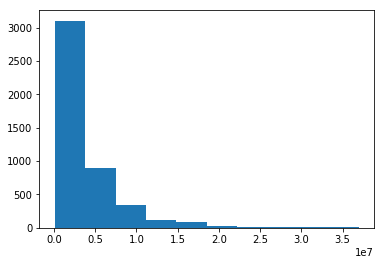

In [19]:
# call dropna to drop unknoown values
plt.hist(df_ineq['poptotal'].dropna());

In [20]:
df_ineq['poptotal'].mean()

3777335.578125

In [21]:
df_ineq['poptotal'].median()

2500000.0

Definitely not normal! Let's try the logarithm.

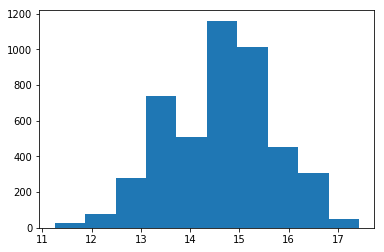

In [22]:
# call dropna to drop unknoown values
plt.hist(np.log(df_ineq['poptotal'].dropna()));

Better! Let's add the log population to the dataframe.

In [24]:
log_pop = np.log2(df_ineq['poptotal'])
# df.assign(key=value) adds a column to the dataframe
df_ineq = df_ineq.assign(logpop=log_pop.values)

In [26]:
# let's create a new dataframe using just the relevant data, dropping NA values
# this is mainly for convenience
df_ineq2 = df_ineq[['state','year','logpop','incshare_top1','gsp_q']].dropna()

In [27]:
result = sm.ols(formula='incshare_top1 ~ logpop', data=df_ineq2).fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.065     
Dependent Variable: incshare_top1    AIC:                13512.5772
Date:               2017-09-13 16:03 BIC:                13524.0981
No. Observations:   2346             Log-Likelihood:     -6754.3   
Df Model:           1                F-statistic:        162.8     
Df Residuals:       2344             Prob (F-statistic): 4.30e-36  
R-squared:          0.065            Scale:              18.562    
---------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------
Intercept   -3.6461     1.2725   -2.8652   0.0042   -6.1415   -1.1507
logpop       0.7553     0.0592   12.7586   0.0000    0.6392    0.8714
-------------------------------------------------------------------
Omnibus:             748.289       Durbin-Watson:          0.211   
Prob(Omnibus):       0.000         Jarque-Bera (JB):       2378.729
Skew:                1.613         Prob(JB):               0.000   
Kurtosis:            6.733         Condition No.:          308     
===================================================================

"""

Better $R^2$, and the coefficient is more interpretable: every doubling of the population is linked to an extra 0.75% share of income to the top 1%

## Plotting fitted values versus residuals

Now let's plot fitted values versus residuals

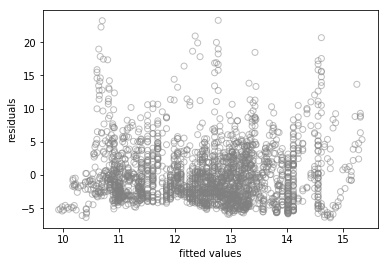

In [28]:
plt.scatter(result.fittedvalues,result.resid,marker='o',alpha=0.5,facecolors='None',edgecolors='gray')
plt.xlabel('fitted values')
plt.ylabel('residuals');

Hard to see a clear trend, and unfortunately statsmodels doesn't seem to make it easy to plot a fit of the predicted values versus residuals.

## Correlated errors

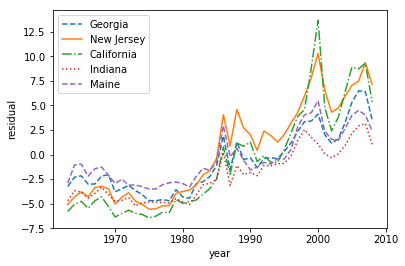

In [29]:
states = ['Georgia','New Jersey','California','Indiana','Maine']
linestyles = ['--','-','-.',':','--']
for linestyle,state in zip(linestyles,states):
    # select rows for this state
    state_entries = (df_ineq2['state']==state)
    plt.plot(df_ineq2[state_entries]['year'],result.resid[state_entries],linestyle=linestyle)
plt.ylabel('residual')
plt.xlabel('year')
plt.legend(states);

In [30]:
# since we're going to use this again, let's package it into a function
def plot_residuals_over_time(df,result,states=['Georgia','New Jersey','California','Indiana','Maine']):
    linestyles = ['--','-','-.',':']
    for i,state in enumerate(states):
        state_entries = (df['state']==state)
        plt.plot(df[state_entries]['year'],result.resid[state_entries],linestyle=linestyles[i%len(linestyles)])
    plt.ylabel('residual')
    plt.xlabel('year')
    plt.legend(states);
    return plt.gcf() # return current figure

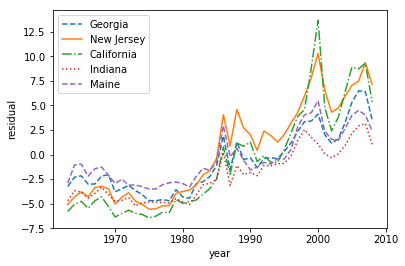

In [31]:
plot_residuals_over_time(df_ineq2,result);

Looks like we have strongly correlated residuals. Let's check the correlation of residuals against time.

In [32]:
from scipy.stats import spearmanr, pearsonr

In [33]:
spearmanr(df_ineq2['year'],result.resid)

SpearmanrResult(correlation=0.77229284365062278, pvalue=0.0)

$\rho=0.77$, so again, strong evidence of correlated errors. This means the IID assumption is likely violated, so our $p$-values are overconfident.

# Multiple regression

One solution is to include the year as a predictor in a multiple regression.

The syntax for describing multiple regressions in statsmodels is `Y ~ X1 + X2 + ...`


In [34]:
result = sm.ols(formula='incshare_top1 ~ logpop + year', data=df_ineq2).fit()

In [35]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.525     
Dependent Variable: incshare_top1    AIC:                11924.0488
Date:               2017-09-13 16:08 BIC:                11941.3302
No. Observations:   2346             Log-Likelihood:     -5959.0   
Df Model:           2                F-statistic:        1296.     
Df Residuals:       2343             Prob (F-statistic): 0.00      
R-squared:          0.525            Scale:              9.4268    
-------------------------------------------------------------------
               Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept    -453.8799   9.4882 -47.8361 0.0000 -472.4860 -435.2737
logpop          0.4807   0.0426  11.2901 0.0000    0.3972    0.5642
year            0.2297   0.0048  47.6701 0.0000    0.2203    0.2392
-------------------------------------------------------------------
Omnibus:              1025.739      Durbin-Watson:         0.274   
Prob(Omnibus):        0.000         Jarque-Bera (JB):      5683.796
Skew:                 2.020         Prob(JB):              0.000   
Kurtosis:             9.468         Condition No.:         297215  
===================================================================
* The condition number is large (3e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

$R^2$ is lots better, and $F$ is higher too. This model is a much better fit. Let's check those residuals again.

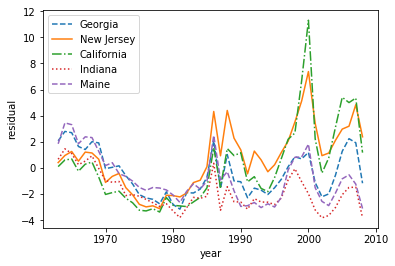

In [36]:
plot_residuals_over_time(df_ineq2,result);

In [37]:
spearmanr(df_ineq2['year'],result.resid)

SpearmanrResult(correlation=-0.13569265162801084, pvalue=4.1286519360780111e-11)

Not great, but definitely better than before.

**Your turn** Run a multiple regression using year, log population, and gross state product (`gsp_q`). You will need to create a new dataframe to do this. See how `df_ineq2` was created above.

In [51]:
# your code here

In [54]:
# here's the output I get
result_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          incshare_top1   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     1028.
Date:                Wed, 13 Sep 2017   Prob (F-statistic):               0.00
Time:                        13:15:44   Log-Likelihood:                -5847.8
No. Observations:                2346   AIC:                         1.170e+04
Df Residuals:                    2342   BIC:                         1.173e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -371.4745     10.538    -35.249      0.000    -392.140    -350.809
logpop        -0.0117      0.052     -0.226      0.821      -0.113       0.090
year           0.1932      0.005     37.260      0.000       0.183       0.203
gsp_q       7.515e-06   4.92e-07     15.264      0.000    6.55e-06    8.48e-06
==============================================================================
Omnibus:                     1016.283   Durbin-Watson:                   0.291
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6220.882
Skew:                           1.956   Prob(JB):                         0.00
Kurtosis:                       9.953   Cond. No.                     3.54e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.54e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

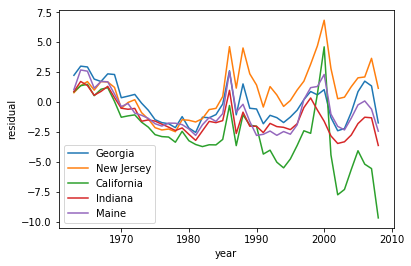

In [58]:
plot_residuals_over_time(df_ineq3,result_full);

Is the full model an improvement?

# Adding a qualitative predictor

Each state is in a geographical region, indicated by a number $\{1,2,3,4\}$.

In [38]:
df_ineq[['state','region_census']].head()

,state,region_census
59,Alaska,2.0
60,Alaska,2.0
61,Alaska,2.0
62,Alaska,2.0
63,Alaska,2.0


In [61]:
df_ineq['region_census'].unique()

array([  2.,  nan,   1.,   4.,   3.])

Let's see what states are included in each region.

In [39]:
for region in sorted(df_ineq['region_census'].unique()):
    print(region,df_ineq[df_ineq['region_census']==region]['state'].unique())

2.0 ['Alaska' 'Arizona' 'California' 'Colorado' 'Hawaii' 'Idaho' 'Montana'
 'New Mexico' 'Nevada' 'Oregon' 'Utah' 'Washington' 'Wyoming']
nan []
1.0 ['Alabama' 'Arkansas' 'District of Columbia' 'Delaware' 'Florida' 'Georgia'
 'Kentucky' 'Louisiana' 'Maryland' 'Mississippi' 'North Carolina'
 'Oklahoma' 'South Carolina' 'Tennessee' 'Texas' 'Virginia' 'West Virginia']
3.0 ['Iowa' 'Illinois' 'Indiana' 'Kansas' 'Michigan' 'Minnesota' 'Missouri'
 'North Dakota' 'Nebraska' 'Ohio' 'South Dakota' 'Wisconsin']
4.0 ['Connecticut' 'Massachusetts' 'Maine' 'New Hampshire' 'New Jersey'
 'New York' 'Pennsylvania' 'Rhode Island' 'Vermont']


First, let's use the region as if it were a quantitative predictor

In [40]:
df_ineq4 = df_ineq[['state','year','logpop','incshare_top1','region_census','gsp_q']].dropna()

In [41]:
# base model
sm.ols(formula='incshare_top1 ~ logpop + year + gsp_q', data=df_ineq4).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.568     
Dependent Variable: incshare_top1    AIC:                11703.5430
Date:               2017-09-13 16:10 BIC:                11726.5849
No. Observations:   2346             Log-Likelihood:     -5847.8   
Df Model:           3                F-statistic:        1028.     
Df Residuals:       2342             Prob (F-statistic): 0.00      
R-squared:          0.568            Scale:              8.5775    
-------------------------------------------------------------------
               Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept    -371.4745  10.5385 -35.2494 0.0000 -392.1402 -350.8088
logpop         -0.0117   0.0519  -0.2261 0.8211   -0.1134    0.0900
year            0.1932   0.0052  37.2602 0.0000    0.1830    0.2033
gsp_q           0.0000   0.0000  15.2644 0.0000    0.0000    0.0000
-------------------------------------------------------------------
Omnibus:              1016.283      Durbin-Watson:         0.291   
Prob(Omnibus):        0.000         Jarque-Bera (JB):      6220.882
Skew:                 1.956         Prob(JB):              0.000   
Kurtosis:             9.953         Condition No.:         35403158
===================================================================
* The condition number is large (4e+07). This might indicate
strong multicollinearity or other numerical problems.
"""

In [65]:
# with region as quantitative predictor
sm.ols(formula='incshare_top1 ~ logpop + year + gsp_q + region_census', data=df_ineq4).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:               OLS              Adj. R-squared:     0.568     
Dependent Variable:  incshare_top1    AIC:                11705.5428
Date:                2017-09-13 13:19 BIC:                11734.3451
No. Observations:    2346             Log-Likelihood:     -5847.8   
Df Model:            4                F-statistic:        770.3     
Df Residuals:        2341             Prob (F-statistic): 0.00      
R-squared:           0.568            Scale:              8.5812    
--------------------------------------------------------------------
                Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
--------------------------------------------------------------------
Intercept     -371.4817  10.5516 -35.2060 0.0000 -392.1733 -350.7902
logpop          -0.0117   0.0519  -0.2251 0.8219   -0.1135    0.0902
year             0.1932   0.0052  37.2362 0.0000    0.1830    0.2033
gsp_q            0.0000   0.0000  15.2266 0.0000    0.0000    0.0000
region_census    0.0008   0.0551   0.0150 0.9880   -0.1073    0.1089
--------------------------------------------------------------------
Omnibus:             1016.247       Durbin-Watson:          0.291   
Prob(Omnibus):       0.000          Jarque-Bera (JB):       6220.091
Skew:                1.956          Prob(JB):               0.000   
Kurtosis:            9.952          Condition No.:          35439858
====================================================================
* The condition number is large (4e+07). This might indicate
strong multicollinearity or other numerical problems.
"""

The coefficient for `region_census` is not signifciant, and the $R^2$ is not better. 

Now let's try adding it as a qualitative predictor, using **dummy variables**. 

We convert `region_census` into a dummy variable with the notation `C(region_census)`.

In [42]:
# with region as quantitative predictor
sm.ols(formula='incshare_top1 ~ logpop + year + gsp_q + C(region_census)', data=df_ineq4).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:                   OLS                 Adj. R-squared:        0.595     
Dependent Variable:      incshare_top1       AIC:                   11555.9234
Date:                    2017-09-13 16:10    BIC:                   11596.2467
No. Observations:        2346                Log-Likelihood:        -5771.0   
Df Model:                6                   F-statistic:           574.2     
Df Residuals:            2339                Prob (F-statistic):    0.00      
R-squared:               0.596               Scale:                 8.0441    
------------------------------------------------------------------------------
                          Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
------------------------------------------------------------------------------
Intercept               -372.9432  10.2710 -36.3104 0.0000 -393.0843 -352.8020
C(region_census)[T.2.0]   -0.8118   0.1631  -4.9779 0.0000   -1.1316   -0.4920
C(region_census)[T.3.0]   -1.4371   0.1577  -9.1145 0.0000   -1.7463   -1.1279
C(region_census)[T.4.0]    0.6534   0.1740   3.7553 0.0002    0.3122    0.9946
logpop                    -0.0275   0.0538  -0.5110 0.6094   -0.1329    0.0780
year                       0.1943   0.0050  38.5990 0.0000    0.1844    0.2042
gsp_q                      0.0000   0.0000  15.0491 0.0000    0.0000    0.0000
------------------------------------------------------------------------------
Omnibus:                 1046.704          Durbin-Watson:             0.309   
Prob(Omnibus):           0.000             Jarque-Bera (JB):          6898.811
Skew:                    1.997             Prob(JB):                  0.000   
Kurtosis:                10.390            Condition No.:             35630149
==============================================================================
* The condition number is large (4e+07). This might indicate
strong multicollinearity or other numerical problems.
"""

Now the $R^2$ has increased from $0.57$ to $0.6$. Furthermore, the dummy variables for all three levels are significant at $p<.05$:

- West: slightly lower inequality than the south
- Midwest: much lower inequality than the south
- Northeast: higher inequality than the south

# Interactions

Different regions may have different socioeconomic conditions over time. To handle this, let's add an interaction term between `year` and `region_census`. We do this in statsmodels using the notation `X1:X2`

In [95]:
sm.ols(formula='incshare_top1 ~ logpop + year + gsp_q + C(region_census) + C(region_census):year', data=df_ineq4).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                    OLS                   Adj. R-squared:          0.614     
Dependent Variable:       incshare_top1         AIC:                     11444.5070
Date:                     2017-09-13 13:31      BIC:                     11502.1117
No. Observations:         2346                  Log-Likelihood:          -5712.3   
Df Model:                 9                     F-statistic:             415.3     
Df Residuals:             2336                  Prob (F-statistic):      0.00      
R-squared:                0.615                 Scale:                   7.6613    
-----------------------------------------------------------------------------------
                               Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-----------------------------------------------------------------------------------
Intercept                    -281.6792  15.7773 -17.8534 0.0000 -312.6182 -250.7401
C(region_census)[T.2.0]      -189.9735  22.5653  -8.4188 0.0000 -234.2237 -145.7234
C(region_census)[T.3.0]       -25.1037  23.0247  -1.0903 0.2757  -70.2546   20.0472
C(region_census)[T.4.0]      -209.0792  25.1909  -8.2998 0.0000 -258.4781 -159.6803
logpop                         -0.0473   0.0529  -0.8952 0.3708   -0.1510    0.0563
year                            0.1485   0.0079  18.9134 0.0000    0.1331    0.1639
C(region_census)[T.2.0]:year    0.0953   0.0114   8.3837 0.0000    0.0730    0.1175
C(region_census)[T.3.0]:year    0.0119   0.0116   1.0279 0.3041   -0.0108    0.0347
C(region_census)[T.4.0]:year    0.1056   0.0127   8.3253 0.0000    0.0807    0.1305
gsp_q                           0.0000   0.0000  15.4630 0.0000    0.0000    0.0000
-----------------------------------------------------------------------------------
Omnibus:                  933.042            Durbin-Watson:               0.328    
Prob(Omnibus):            0.000              Jarque-Bera (JB):            5304.278 
Skew:                     1.793              Prob(JB):                    0.000    
Kurtosis:                 9.435              Condition No.:               120945418
===================================================================================
* The condition number is large (1e+08). This might indicate             strong
multicollinearity or other numerical problems.
"""

A more compact notation is `X1*X2`, which automatically adds individual terms for `X1` and `X2`

In [43]:
sm.ols(formula='incshare_top1 ~ logpop + gsp_q + C(region_census)*year', data=df_ineq4).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                    OLS                   Adj. R-squared:          0.614     
Dependent Variable:       incshare_top1         AIC:                     11444.5070
Date:                     2017-09-13 16:11      BIC:                     11502.1117
No. Observations:         2346                  Log-Likelihood:          -5712.3   
Df Model:                 9                     F-statistic:             415.3     
Df Residuals:             2336                  Prob (F-statistic):      0.00      
R-squared:                0.615                 Scale:                   7.6613    
-----------------------------------------------------------------------------------
                               Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-----------------------------------------------------------------------------------
Intercept                    -281.6792  15.7773 -17.8534 0.0000 -312.6182 -250.7401
C(region_census)[T.2.0]      -189.9735  22.5653  -8.4188 0.0000 -234.2237 -145.7234
C(region_census)[T.3.0]       -25.1037  23.0247  -1.0903 0.2757  -70.2546   20.0472
C(region_census)[T.4.0]      -209.0792  25.1909  -8.2998 0.0000 -258.4781 -159.6803
logpop                         -0.0473   0.0529  -0.8952 0.3708   -0.1510    0.0563
gsp_q                           0.0000   0.0000  15.4630 0.0000    0.0000    0.0000
year                            0.1485   0.0079  18.9134 0.0000    0.1331    0.1639
C(region_census)[T.2.0]:year    0.0953   0.0114   8.3837 0.0000    0.0730    0.1175
C(region_census)[T.3.0]:year    0.0119   0.0116   1.0279 0.3041   -0.0108    0.0347
C(region_census)[T.4.0]:year    0.1056   0.0127   8.3253 0.0000    0.0807    0.1305
-----------------------------------------------------------------------------------
Omnibus:                  933.042            Durbin-Watson:               0.328    
Prob(Omnibus):            0.000              Jarque-Bera (JB):            5304.278 
Skew:                     1.793              Prob(JB):                    0.000    
Kurtosis:                 9.435              Condition No.:               120945418
===================================================================================
* The condition number is large (1e+08). This might indicate             strong
multicollinearity or other numerical problems.
"""

**Your turn**: add another interaction term, between `logpop` and `gsp_q`.

In [100]:
# your code here

# Predictive evaluation

The interaction model has higher $R^2$, but will it be better on out-of-sample data? 

To answer this, let's divide our dataset into **training** and **test**, using the year 2005 as a split point.

In [44]:
df_train = df_ineq4[df_ineq4['year']<2005]
df_test = df_ineq4[df_ineq4['year']>=2005]
print(len(df_train),len(df_test))

2142 204


In [46]:
model = sm.ols(formula='incshare_top1 ~ logpop + year + gsp_q + C(region_census)', data=df_train).fit()

In [47]:
preds = model.predict(exog=df_test)

R=0.427643


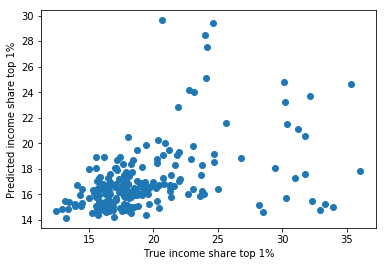

In [49]:
plt.scatter(df_test['incshare_top1'],preds)
plt.ylabel('Predicted income share top 1%')
plt.xlabel('True income share top 1%');
print("R=%f"%(pearsonr(df_test['incshare_top1'],preds)[0]))

Now let's try the model with interactions.

In [51]:
model_full = sm.ols(formula='incshare_top1 ~ logpop*gsp_q + year * gsp_q + year*C(region_census)', data=df_train).fit()

In [52]:
preds = model_full.predict(exog=df_test)

R=0.549012


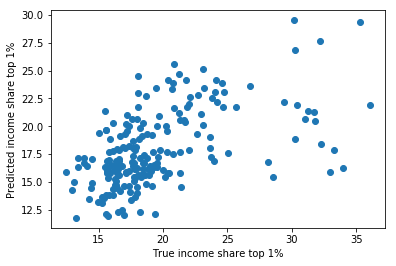

In [53]:
plt.scatter(df_test['incshare_top1'],preds)
plt.ylabel('Predicted income share top 1%')
plt.xlabel('True income share top 1%');
print("R=%f"%(pearsonr(df_test['incshare_top1'],preds)[0]))

The model with interactions is better on out-of-sample data too. 

This provides additional evidence that the interaction terms capture a meaningful aspect of the problem.

**Your turn** Add three more predictors:

- `kegreg`: "Did State adopt Beer Keg Registration Requirement?"
- `gambling_lottery_adoption`: "Does the state have a lottery?"
- `beaulic`: "Did State adopt Beauticians Licensing?"

These predictors seem unlikely to be related to income inequality. Does adding them improve the in-sample $R^2$? What about the out-of-sample $R^2$?

In [161]:
# create a new dataset
df_ineq5 = df_ineq[['state','year','logpop','incshare_top1','region_census','gsp_q',
                    'kegreg','gambling_lottery_adoption','beaulic']].dropna()
df_train = df_ineq5[df_ineq5['year']<2005]
df_test = df_ineq5[df_ineq5['year']>=2005]
print(len(df_train),len(df_test))

2050 200


In [162]:
#your code here

# Does the minimum wage reduce income inequality?

One way to reduce income inequality is to put a lower bound on the minimum income. Does this work?

States have varying minimum wages:

In [72]:
# use dropna to restrict dataframe to cases in which minimum wage information is available
df_hasmin =df_ineq[['state','year','logpop','incshare_top1','gsp_q','statemin','region_census']].dropna()

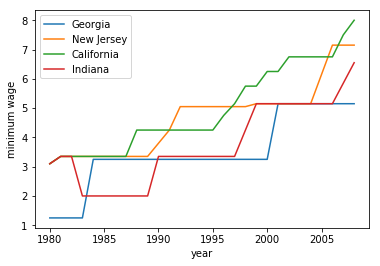

In [74]:
for state in states:
    df_state = df_hasmin[df_hasmin['state']==state]
    plt.plot(df_state['year'],df_state['statemin'])
plt.xlabel('year')
plt.ylabel('minimum wage')
plt.legend(states);

These minimum wage statistics are not adjusted for inflation. We'll tackle that later.

For now, let's fit a baseline model. Note that we are considering a different dataframe, so the $R^2$ is not comparable to what we had before.

In [163]:
sm.ols(formula='incshare_top1 ~ logpop * gsp_q + year * C(region_census)', data=df_hasmin).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                     OLS                   Adj. R-squared:          0.593    
Dependent Variable:        incshare_top1         AIC:                     7309.2322
Date:                      2017-09-13 14:05      BIC:                     7367.5225
No. Observations:          1479                  Log-Likelihood:          -3643.6  
Df Model:                  10                    F-statistic:             216.3    
Df Residuals:              1468                  Prob (F-statistic):      2.97e-280
R-squared:                 0.596                 Scale:                   8.1395   
-----------------------------------------------------------------------------------
                               Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-----------------------------------------------------------------------------------
Intercept                    -134.3956  40.0843  -3.3528 0.0008 -213.0243  -55.7670
C(region_census)[T.2.0]      -394.2750  47.4945  -8.3015 0.0000 -487.4394 -301.1106
C(region_census)[T.3.0]        -1.6199  47.6248  -0.0340 0.9729  -95.0397   91.8000
C(region_census)[T.4.0]      -263.8648  52.1305  -5.0616 0.0000 -366.1231 -161.6065
logpop                         -0.8640   0.1050  -8.2307 0.0000   -1.0699   -0.6581
gsp_q                           0.0002   0.0000  13.2125 0.0000    0.0002    0.0003
logpop:gsp_q                   -0.0000   0.0000 -12.8898 0.0000   -0.0000   -0.0000
year                            0.0820   0.0196   4.1847 0.0000    0.0436    0.1205
year:C(region_census)[T.2.0]    0.1978   0.0238   8.3036 0.0000    0.1511    0.2445
year:C(region_census)[T.3.0]    0.0001   0.0239   0.0027 0.9978   -0.0468    0.0469
year:C(region_census)[T.4.0]    0.1328   0.0261   5.0812 0.0000    0.0816    0.1841
-----------------------------------------------------------------------------------
Omnibus:                   469.896           Durbin-Watson:              0.420     
Prob(Omnibus):             0.000             Jarque-Bera (JB):           1868.519  
Skew:                      1.491             Prob(JB):                   0.000     
Kurtosis:                  7.629             Condition No.:              5898391492
===================================================================================
* The condition number is large (6e+09). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [164]:
sm.ols(formula='incshare_top1 ~ logpop * gsp_q + year * C(region_census) + statemin', data=df_hasmin).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                     OLS                   Adj. R-squared:          0.596    
Dependent Variable:        incshare_top1         AIC:                     7298.1100
Date:                      2017-09-13 14:05      BIC:                     7361.6995
No. Observations:          1479                  Log-Likelihood:          -3637.1  
Df Model:                  11                    F-statistic:             199.5    
Df Residuals:              1467                  Prob (F-statistic):      6.86e-282
R-squared:                 0.599                 Scale:                   8.0731   
-----------------------------------------------------------------------------------
                               Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-----------------------------------------------------------------------------------
Intercept                    -222.9848  46.8395  -4.7606 0.0000 -314.8644 -131.1052
C(region_census)[T.2.0]      -414.6153  47.6338  -8.7042 0.0000 -508.0528 -321.1777
C(region_census)[T.3.0]         3.3081  47.4497   0.0697 0.9444  -89.7683   96.3846
C(region_census)[T.4.0]      -279.1369  52.0890  -5.3588 0.0000 -381.3138 -176.9600
logpop                         -0.8962   0.1049  -8.5421 0.0000   -1.1020   -0.6904
gsp_q                           0.0002   0.0000  13.4550 0.0000    0.0002    0.0003
logpop:gsp_q                   -0.0000   0.0000 -13.1239 0.0000   -0.0000   -0.0000
year                            0.1276   0.0232   5.4914 0.0000    0.0821    0.1732
year:C(region_census)[T.2.0]    0.2080   0.0239   8.7067 0.0000    0.1611    0.2549
year:C(region_census)[T.3.0]   -0.0024   0.0238  -0.1026 0.9183   -0.0491    0.0442
year:C(region_census)[T.4.0]    0.1406   0.0261   5.3808 0.0000    0.0893    0.1918
statemin                       -0.4011   0.1109  -3.6157 0.0003   -0.6187   -0.1835
-----------------------------------------------------------------------------------
Omnibus:                   457.610           Durbin-Watson:              0.421     
Prob(Omnibus):             0.000             Jarque-Bera (JB):           1721.818  
Skew:                      1.470             Prob(JB):                   0.000     
Kurtosis:                  7.393             Condition No.:              5924465921
===================================================================================
* The condition number is large (6e+09). This might indicate             strong
multicollinearity or other numerical problems.
"""

`statemin` has a negative coefficient, but the fit is only marginally better.

As noted above, `statemin` is not adjusted for inflation. We can try to do this using `nat_cpi_bls_quar`, which is a measure of inflation from the **b**ureau of **l**abor and **s**tatistics.

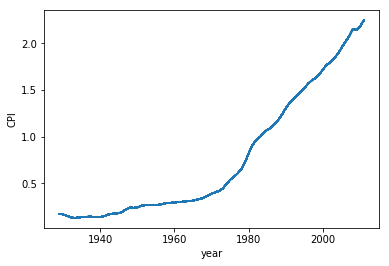

In [165]:
plt.plot(df_ineq['year'],df_ineq['nat_cpi_bls_quar']);
plt.xlabel('year')
plt.ylabel('CPI');

In [166]:
# use dropna to restrict dataframe to cases in which minimum wage information is available
df_hasmin =df_ineq[['state','year','logpop','incshare_top1','gsp_q','statemin','region_census','nat_cpi_bls_quar']].dropna()

In [167]:
sm.ols(formula='incshare_top1 ~ logpop *gsp_q + year * C(region_census) + statemin', data=df_hasmin).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                     OLS                   Adj. R-squared:          0.596    
Dependent Variable:        incshare_top1         AIC:                     7298.1100
Date:                      2017-09-13 14:06      BIC:                     7361.6995
No. Observations:          1479                  Log-Likelihood:          -3637.1  
Df Model:                  11                    F-statistic:             199.5    
Df Residuals:              1467                  Prob (F-statistic):      6.86e-282
R-squared:                 0.599                 Scale:                   8.0731   
-----------------------------------------------------------------------------------
                               Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-----------------------------------------------------------------------------------
Intercept                    -222.9848  46.8395  -4.7606 0.0000 -314.8644 -131.1052
C(region_census)[T.2.0]      -414.6153  47.6338  -8.7042 0.0000 -508.0528 -321.1777
C(region_census)[T.3.0]         3.3081  47.4497   0.0697 0.9444  -89.7683   96.3846
C(region_census)[T.4.0]      -279.1369  52.0890  -5.3588 0.0000 -381.3138 -176.9600
logpop                         -0.8962   0.1049  -8.5421 0.0000   -1.1020   -0.6904
gsp_q                           0.0002   0.0000  13.4550 0.0000    0.0002    0.0003
logpop:gsp_q                   -0.0000   0.0000 -13.1239 0.0000   -0.0000   -0.0000
year                            0.1276   0.0232   5.4914 0.0000    0.0821    0.1732
year:C(region_census)[T.2.0]    0.2080   0.0239   8.7067 0.0000    0.1611    0.2549
year:C(region_census)[T.3.0]   -0.0024   0.0238  -0.1026 0.9183   -0.0491    0.0442
year:C(region_census)[T.4.0]    0.1406   0.0261   5.3808 0.0000    0.0893    0.1918
statemin                       -0.4011   0.1109  -3.6157 0.0003   -0.6187   -0.1835
-----------------------------------------------------------------------------------
Omnibus:                   457.610           Durbin-Watson:              0.421     
Prob(Omnibus):             0.000             Jarque-Bera (JB):           1721.818  
Skew:                      1.470             Prob(JB):                   0.000     
Kurtosis:                  7.393             Condition No.:              5924465921
===================================================================================
* The condition number is large (6e+09). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [169]:
# let's add adjusted minimum wage as a column in the dataframe
df_hasmin = df_hasmin.assign(adj_min=df_hasmin['statemin']/df_hasmin['nat_cpi_bls_quar']);

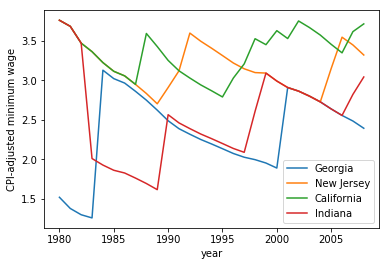

In [170]:
# plotting adjusted minimum wage over time
for state in states:
    df_state = df_hasmin[df_hasmin['state']==state]
    plt.plot(df_state['year'],df_state['adj_min'])
plt.xlabel('year')
plt.ylabel('CPI-adjusted minimum wage')
plt.legend(states);

In [171]:
sm.ols(formula='incshare_top1 ~ logpop *gsp_q + year * C(region_census) + adj_min', data=df_hasmin).fit().summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                     OLS                   Adj. R-squared:          0.595    
Dependent Variable:        incshare_top1         AIC:                     7301.8806
Date:                      2017-09-13 14:06      BIC:                     7365.4701
No. Observations:          1479                  Log-Likelihood:          -3638.9  
Df Model:                  11                    F-statistic:             198.6    
Df Residuals:              1467                  Prob (F-statistic):      4.42e-281
R-squared:                 0.598                 Scale:                   8.0937   
-----------------------------------------------------------------------------------
                               Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-----------------------------------------------------------------------------------
Intercept                    -121.9237  40.1800  -3.0344 0.0025 -200.7399  -43.1074
C(region_census)[T.2.0]      -407.6743  47.5640  -8.5711 0.0000 -500.9750 -314.3736
C(region_census)[T.3.0]         0.7401  47.4969   0.0156 0.9876  -92.4290   93.9092
C(region_census)[T.4.0]      -265.7218  51.9873  -5.1113 0.0000 -367.6992 -163.7445
logpop                         -0.8827   0.1049  -8.4183 0.0000   -1.0883   -0.6770
gsp_q                           0.0002   0.0000  13.3648 0.0000    0.0002    0.0003
logpop:gsp_q                   -0.0000   0.0000 -13.0367 0.0000   -0.0000   -0.0000
year                            0.0767   0.0196   3.9064 0.0001    0.0382    0.1152
year:C(region_census)[T.2.0]    0.2045   0.0239   8.5733 0.0000    0.1577    0.2513
year:C(region_census)[T.3.0]   -0.0011   0.0238  -0.0481 0.9616   -0.0479    0.0456
year:C(region_census)[T.4.0]    0.1338   0.0261   5.1332 0.0000    0.0827    0.1850
adj_min                        -0.4844   0.1588  -3.0504 0.0023   -0.7960   -0.1729
-----------------------------------------------------------------------------------
Omnibus:                   463.989           Durbin-Watson:              0.425     
Prob(Omnibus):             0.000             Jarque-Bera (JB):           1778.471  
Skew:                      1.485             Prob(JB):                   0.000     
Kurtosis:                  7.477             Condition No.:              5907762344
===================================================================================
* The condition number is large (6e+09). This might indicate             strong
multicollinearity or other numerical problems.
"""

Sadly, adjusting for inflation doesn't seem to have changed much.